## Imports

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ac; ac.set_theme()
import pandas as pd
from deepkt import deepkt, data_util, metrics
import tensorflow as tf
import networkx as nx

## Define Hyperparameters

In [190]:
fn = "data/moocData.csv" # Dataset path
verbose = 1 # Verbose = {0,1,2}
best_model_weights = "weights/bestmodel" # File to save the model.
log_dir = "logs" # Path to save the logs.
optimizer = "adam" # Optimizer to use
lstm_units = 100 # Number of LSTM units
batch_size = 32 # Batch size
epochs = 20 # Number of epochs to train
dropout_rate = 0.3 # Dropout rate
test_fraction = 0.2 # Portion of data to be used for testing
validation_fraction = 0.1 # Portion of training data to be used for validation

## Split Dataset

In [191]:
dataset, length, nb_features, nb_skills = data_util.load_dataset(fn=fn,
                                                                 batch_size=batch_size,
                                                                 shuffle=True)

train_set, test_set, val_set = data_util.split_dataset(dataset=dataset,
                                                       total_size=length,
                                                       test_fraction=test_fraction,
                                                       val_fraction=validation_fraction)


set_sz = length * batch_size
test_set_sz = (set_sz * test_fraction)
val_set_sz = (set_sz - test_set_sz) * validation_fraction
train_set_sz = set_sz - test_set_sz - val_set_sz
print("============= Data Summary =============")
print("Total number of students: %d" % set_sz)
print("Training set size: %d" % train_set_sz)
print("Validation set size: %d" % val_set_sz)
print("Testing set size: %d" % test_set_sz)
print("Number of skills: %d" % nb_skills)
print("Number of features in the input: %d" % nb_features)
print("========================================")

============= Data Summary =============
Total number of students: 1504
Training set size: 1082
Validation set size: 120
Testing set size: 300
Number of skills: 170
Number of features in the input: 340


## Create MOOC-170 DKT Model

In [192]:
batch_size=1

train_length=train_set_sz // batch_size
val_length=val_set_sz // batch_size

student_model = deepkt.DKTModel(
                        nb_features=nb_features,
                        nb_skills=nb_skills,
                        hidden_units=lstm_units,
                        dropout_rate=dropout_rate)

student_model.compile(
        optimizer=optimizer,
        metrics=[
            metrics.BinaryAccuracy(),
            metrics.AUC(),
            metrics.Precision(),
            metrics.Recall()
        ])

student_model.summary()

Model: "DKTModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 340)]       0         
_________________________________________________________________
masking_6 (Masking)          (None, None, 340)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 100)         176400    
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 170)         17170     
Total params: 193,570
Trainable params: 193,570
Non-trainable params: 0
_________________________________________________________________


## Train MOOC-170 Model

In [127]:
history = student_model.fit(dataset=train_set,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=val_set,
                            callbacks=[
                                tf.keras.callbacks.CSVLogger(f"{log_dir}/train.log"),
                                tf.keras.callbacks.ModelCheckpoint(best_model_weights,
                                                                   save_best_only=True,
                                                                   save_weights_only=True),
                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        ])

Epoch 1/20


2022-06-06 19:47:02.501655: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_142590_144047' and '__inference___backward_standard_lstm_145345_145942_specialized_for_training_4_Adam_gradients_gradients_lstm_4_StatefulPartitionedCall_grad_StatefulPartitionedCall_at___inference_keras_scratch_graph_146594' both implement 'lstm_8652c2fb-de4c-4e30-96cb-7c355d57ef7a' but their signatures do not match.


      1/Unknown - 2s 2s/step - loss: 0.6928 - binary_accuracy: 0.4737 - auc_4: 0.5046 - precision_4: 0.6222 - recall_4: 0.4590

2022-06-06 19:47:03.039153: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


1100/1100 [==============================] - 36s 32ms/step - loss: 0.5085 - binary_accuracy: 0.7697 - auc_4: 0.7305 - precision_4: 0.8039 - recall_4: 0.9194 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/20
1100/1100 [==============================] - 30s 27ms/step - loss: 0.4564 - binary_accuracy: 0.7921 - auc_4: 0.7852 - precision_4: 0.8227 - recall_4: 0.9266 - val_loss: 0.4345 - val_binary_accuracy: 0.8002 - val_auc_4: 0.8061 - val_precision_4: 0.8233 - val_recall_4: 0.9312
Epoch 3/20
1100/1100 [==============================] - 28s 26ms/step - loss: 0.4495 - binary_accuracy: 0.8014 - auc_4: 0.8088 - precision_4: 0.8313 - recall_4: 0.9248 - val_loss: 0.4322 - val_binary_accuracy: 0.8195 - val_auc_4: 0.8184 - val_precision_4: 0.8421 - val_recall_4: 0.9474
Epoch 4/20
1100/1100 [==============================] - 28s 26ms/step - loss: 0.4271 - binary_accuracy: 0.8129 - auc_4: 0.8208 - prec

## Load Best Model Weights

In [193]:
student_model.load_weights(best_model_weights)

## Test MOOC-170 Model

In [197]:
result = student_model.evaluate(test_set, verbose=verbose)

2022-06-06 21:38:30.742571: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_692244' and '__inference_standard_lstm_691903_specialized_for_lstm_6_StatefulPartitionedCall_at___inference_keras_scratch_graph_695182' both implement 'lstm_e18f9680-5c13-4b4c-97e5-ad7f2bf35792' but their signatures do not match.


     10/Unknown - 2s 187ms/step - loss: 0.0959 - binary_accuracy: 0.8421 - auc_6: 0.8578 - precision_6: 0.8670 - recall_6: 0.9424

### Take One Sample from Data

In [200]:
def get_element_by_index(data_set,candidate_index):
    """
    This function gets one sample in dataset
    by index
    """
    for raw_index,candidate in enumerate(data_set):

        if raw_index == candidate_index:
            candidate_desired = candidate
            return candidate_desired

## Implement Scenario-2
### Algorithm-1

In [201]:

y_gr_lst=[]
err_calculation_matrix=np.zeros((170,1))
err_counter_matrix=np.zeros((170,1))

for i in range(int(test_set_sz)):
    if i== 210:
        continue
    student_desired=get_element_by_index(test_set,i)

    #student array
    tmp_s=student_desired[0][0]
    l,_=tmp_s.shape
    tmp_y_gr=np.zeros((170,1))
    #calculate ground truth
    #begin
    for j in range(l):
        tmp_index=np.where(tmp_s[j] == 1)[0][0]
        real_index=int(tmp_index/2)
        real_val=tmp_index%2
        tmp_y_gr[j]=real_val
    #end
    #make prediction
    #begin
    err_list_total=[]
    for k in range(l):
        s1=tf.reshape(student_desired[0][0][0:k+1], [1, k+1,340])
        pr=student_model.predict(s1)
        x,y,z = pr.shape
        total=0
        for a in range(y):
            total=abs(pr[0][a][a]-tmp_y_gr[a])+total
        err_calculation_matrix[k]=err_calculation_matrix[k]+total/y
        err_counter_matrix[k]=err_counter_matrix[k]+1
        # err_list_total.append(total/y)
    #end

IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
# Calculate Error for Test Set
test_set_error = err_calculation_matrix/err_counter_matrix

array([[0.25425145],
       [0.15349195],
       [0.15809734],
       [0.23328961],
       [0.26208079],
       [0.25278614],
       [0.25319658],
       [0.25308917],
       [0.2436357 ],
       [0.24451515],
       [0.26081789],
       [0.25193373],
       [0.25711766],
       [0.25443548],
       [0.26049395],
       [0.26328881],
       [0.26687842],
       [0.27185144],
       [0.27685643],
       [0.27479978],
       [0.27606864],
       [0.2739225 ],
       [0.27085287],
       [0.27322073],
       [0.2768095 ],
       [0.27303558],
       [0.26752904],
       [0.26006881],
       [0.25588779],
       [0.25803127],
       [0.25615055],
       [0.25729401],
       [0.25418062],
       [0.25140104],
       [0.24511169],
       [0.24396385],
       [0.24151987],
       [0.23981185],
       [0.24011855],
       [0.24051772],
       [0.24068131],
       [0.23996818],
       [0.24463835],
       [0.24703374],
       [0.2513029 ],
       [0.25033666],
       [0.24656747],
       [0.248

In [ ]:
# Plot Error for Test Set
plt.plot(test_set_error)
plt.ylabel('error')
plt.xlabel('Question tag')
plt.axhline(y=0, color='k')
plt.axhline(y=0.4, color='w')
plt.axvline(x=175, color='w')
plt.show()

## Scenario-1

In [130]:
def return_question_sample_correct(end):
    """
    This function creates virtual
    student who answers 170 questions
    correctly
    """
    dummy_input=np.zeros((1,end,340))
    for i in range (end):
        dummy_input[0][i][2*i+1] = 1
    return dummy_input

In [131]:
student_answers=[]
for i in range(1,170):
    temp_input=return_question_sample_correct(i)
    student_answers.append(temp_input)
#print(len(student_answers))

In [132]:
# Calculates error value for sequentially answered questions
from tensorflow_core import float32
err_list=[]
for answer in student_answers:
    # print(answer.shape)
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    total=0
    for i in range(y-1):
        total=abs(answer_prediction[0][i][i]-1)+total
    err_list.append(total/y)

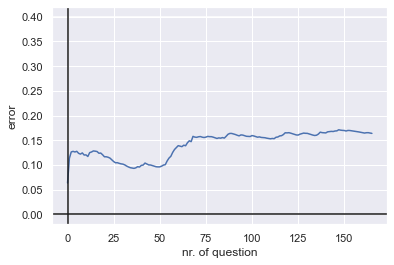

In [161]:
# Figure-1 for Scenario-1 Sequentially Answered Questions
plt.plot(err_list[3:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0.4, color='w')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

In [155]:
def random_student_question(answer_list_random,question):
    """
    This function creates virtual
    student who answers 170 questions
    correctly in random order
    """
    dummy_input=np.zeros((1,question,340))
    for i in range (question):
        dummy_input[0][i][2*answer_list_random[i]+1] = 1
    return dummy_input


In [180]:
import random
indexes = random.sample(range(0,170),169)
indexes

[153,
 56,
 107,
 19,
 33,
 165,
 93,
 59,
 52,
 10,
 148,
 105,
 81,
 113,
 3,
 126,
 27,
 164,
 2,
 8,
 17,
 43,
 31,
 12,
 159,
 90,
 16,
 150,
 95,
 121,
 115,
 151,
 157,
 114,
 135,
 14,
 7,
 147,
 13,
 63,
 91,
 9,
 106,
 110,
 169,
 34,
 166,
 96,
 123,
 83,
 20,
 128,
 119,
 142,
 80,
 28,
 29,
 94,
 25,
 39,
 21,
 36,
 139,
 120,
 54,
 61,
 85,
 160,
 70,
 87,
 15,
 32,
 137,
 122,
 145,
 152,
 79,
 11,
 118,
 41,
 88,
 30,
 134,
 24,
 125,
 44,
 155,
 99,
 146,
 42,
 75,
 138,
 168,
 58,
 26,
 84,
 117,
 67,
 129,
 109,
 73,
 140,
 47,
 163,
 66,
 38,
 45,
 55,
 71,
 35,
 77,
 143,
 50,
 144,
 23,
 108,
 60,
 124,
 37,
 161,
 69,
 86,
 154,
 92,
 1,
 156,
 5,
 149,
 167,
 116,
 89,
 4,
 53,
 49,
 48,
 131,
 158,
 127,
 76,
 74,
 65,
 98,
 112,
 18,
 103,
 101,
 162,
 68,
 100,
 0,
 64,
 51,
 46,
 111,
 22,
 62,
 57,
 97,
 132,
 102,
 78,
 82,
 136,
 72,
 130,
 133,
 141,
 104,
 6]

In [181]:
student_answers_random=[]
for i in range(1,170):
    temp_input=random_student_question(indexes,i)
    student_answers_random.append(temp_input)
print(len(student_answers_random))

169


In [182]:
# Calculates error value for randomly answered questions
from tensorflow_core import float32
err_list_random_total=[]
for i,answer in enumerate (student_answers_random):
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    total=0
    for i in range(y):
        total=abs(answer_prediction[0][i][indexes[i]]-1)+total
    err_list_random_total.append(total/y)

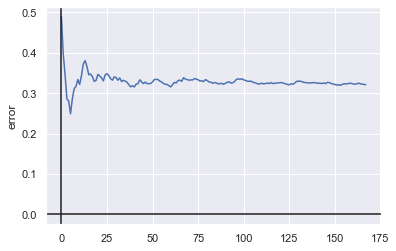

In [183]:
# Figure-1 for Scenario-1 Randomly Answered Questions
plt.plot(err_list_random_total[1:])
plt.ylabel('error')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

### Scnerio-3

In [140]:
import random
random.sample(range(1, 100), 3)

[41, 44, 55]

In [141]:
def return_sample(begin,end,true_fraction):
    """
    This function creates virtual
    student for Scnerio-3
    """
    limit_index = int((end-begin)*true_fraction)
    dummy_input=np.zeros((1,170,340))
    dummy_y=np.zeros((170,1))
    indexes = random.sample(range(begin,end),limit_index)
    for i in range(begin,end):
        if i not in indexes:
            dummy_input[0][i][2*i] = 1
            dummy_y[i][0] = 0
        else:
            dummy_input[0][i][2*i+1] = 1
            dummy_y[i][0] = 1
    return dummy_input,dummy_y

In [142]:
correct_fraction = 0.9

cluster_one_x_true,cluster_one_y_true = return_sample(0,53,correct_fraction)
cluster_two_x_true,cluster_two_y_true = return_sample(53,110,correct_fraction)
cluster_three_x_true,cluster_three_y_true = return_sample(110,170,correct_fraction)


In [143]:
cluster_one_x_false,cluster_one_y_false = return_sample(0,53,1-correct_fraction)
cluster_two_x_false,cluster_two_y_false = return_sample(53,110,1-correct_fraction)
cluster_three_x_false,cluster_three_y_false = return_sample(110,170,1-correct_fraction)

In [144]:
case_1_x = cluster_one_x_false + cluster_two_x_false + cluster_three_x_false
case_1_y = cluster_one_y_false + cluster_two_y_false + cluster_three_y_false

case_2_x = cluster_one_x_true + cluster_two_x_false + cluster_three_x_false
case_2_y = cluster_one_y_true + cluster_two_y_false + cluster_three_y_false

case_3_x = cluster_one_x_false + cluster_two_x_true + cluster_three_x_false
case_3_y = cluster_one_y_false + cluster_two_y_true + cluster_three_y_false

case_4_x = cluster_one_x_true + cluster_two_x_true + cluster_three_x_false
case_4_y = cluster_one_y_true + cluster_two_y_true + cluster_three_y_false

case_5_x = cluster_one_x_false + cluster_two_x_false + cluster_three_x_true
case_5_y = cluster_one_y_false + cluster_two_y_false + cluster_three_y_true

case_6_x = cluster_one_x_true + cluster_two_x_false + cluster_three_x_true
case_6_y = cluster_one_y_true + cluster_two_y_false + cluster_three_y_true

case_7_x = cluster_one_x_false + cluster_two_x_true + cluster_three_x_true
case_7_y = cluster_one_y_false + cluster_two_y_true + cluster_three_y_true

case_8_x = cluster_one_x_true + cluster_two_x_true + cluster_three_x_true
case_8_y = cluster_one_y_true + cluster_two_y_true + cluster_three_y_true

In [145]:
def cases_error (case_x,case_y):
    """
    This function calculates case error
    for Scnerio-3
    """
    case_x_error=[]
    for i in range (170):
        answer_tensor = tf.convert_to_tensor(case_x[0][0:i+1].reshape((1,i+1,340)),dtype=float32)
        answer_prediction = student_model.predict(answer_tensor)
        x,y,z = answer_prediction.shape
        total=0
        for j in range(y):
            total=abs(answer_prediction[0][j][j]-case_y[j])+total
        case_x_error.append(total/y)
    return case_x_error


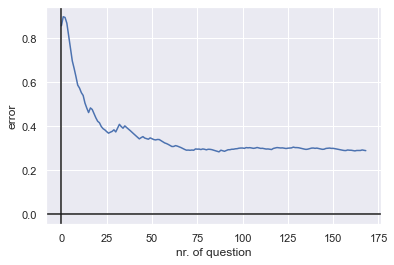

In [146]:
# Error Plot for Scenario-3 Case-1
error_1=cases_error(case_1_x,case_1_y)
plt.plot(error_1[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

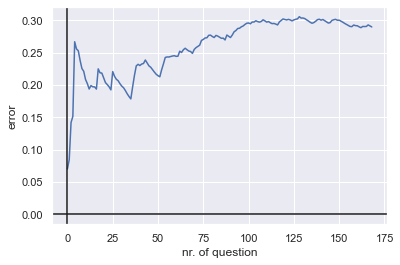

In [147]:
# Error Plot for Scenario-3 Case-2
error_2=cases_error(case_2_x,case_2_y)
plt.plot(error_2[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

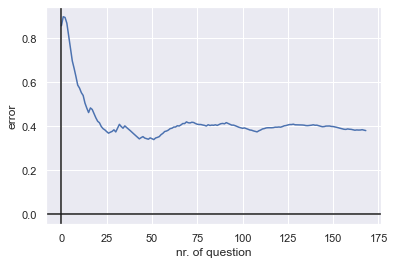

In [148]:
# Error Plot for Scenario-3 Case-3
error_3=cases_error(case_3_x,case_3_y)
plt.plot(error_3[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

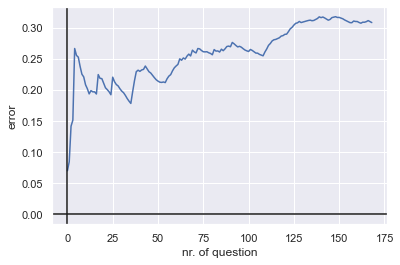

In [149]:
# Error Plot for Scenario-3 Case-4
error_4=cases_error(case_4_x,case_4_y)
plt.plot(error_4[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

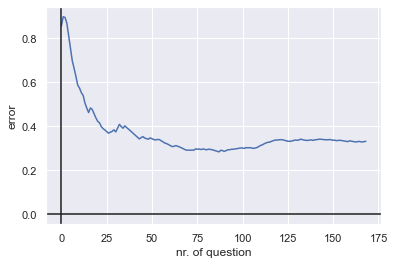

In [150]:
# Error Plot for Scenario-3 Case-5
error_5=cases_error(case_5_x,case_5_y)
plt.plot(error_5[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

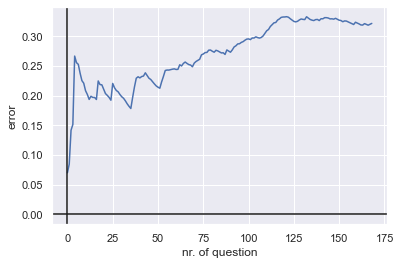

In [151]:
# Error Plot for Scenario-3 Case-6
error_6=cases_error(case_6_x,case_6_y)
plt.plot(error_6[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

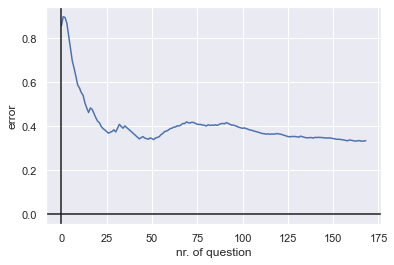

In [152]:
# Error Plot for Scenario-3 Case-7
error_7=cases_error(case_7_x,case_7_y)
plt.plot(error_7[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

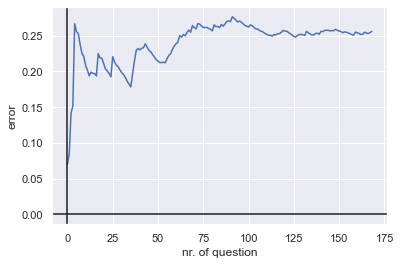

In [153]:
# Error Plot for Scenario-3 Case-8
error_8=cases_error(case_8_x,case_8_y)
plt.plot(error_8[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

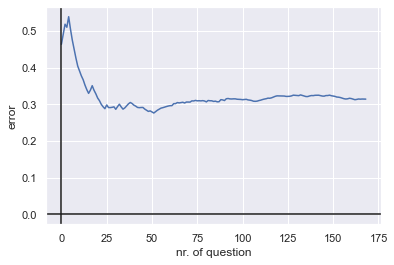

In [154]:
# Error Plot for Scenario-3 for All Cases
error_cases_total= np.array(error_1)+np.array(error_2)+np.array(error_3)+np.array(error_4)+np.array(error_5)+np.array(error_6)+np.array(error_7)+np.array(error_8)
error_cases_total_result=error_cases_total/8
plt.plot(error_cases_total_result[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()


## Discovering Skill Relation

In [ ]:
# Create Student Who Answers All Question Correctly
sample1 = np.zeros((1, 170, 340))
for i in range(170):
    sample1[0][i][2 * i + 1] = 1

In [ ]:
from tensorflow_core import float32
predictedTensor=tf.convert_to_tensor(sample1,dtype=float32)

In [ ]:
student_prediction=tf.expand_dims(predictedTensor, axis=0)

In [15]:
prediction_of_one_student=student_model.predict(tf.squeeze(student_prediction,axis=0))[0]
print(prediction_of_one_student.shape) #This is how the prediction output looks like
print(tf.squeeze(student_prediction,axis=0).shape)#this is how the input looks like see paper intuition doubling the skill_size
prediction_of_one_student[10] #prediction of last time step

(170, 170)
(1, 170, 340)


array([0.95075274, 0.99999523, 0.9998394 , 0.7623473 , 0.8026205 ,
       0.9740617 , 0.94148064, 0.9399883 , 0.96881115, 0.91979146,
       0.8751735 , 0.97477293, 0.9035233 , 0.9374162 , 0.5475346 ,
       0.7944511 , 0.73661566, 0.6579166 , 0.7030196 , 0.86756855,
       0.53079677, 0.7695028 , 0.801406  , 0.3393343 , 0.5529065 ,
       0.911783  , 0.9159709 , 0.96605337, 0.87732786, 0.739063  ,
       0.90689784, 0.65872025, 0.8834579 , 0.8804215 , 0.9207723 ,
       0.7810843 , 0.8200296 , 0.7975786 , 0.76657826, 0.7033586 ,
       0.52631646, 0.7945242 , 0.5137107 , 0.5218361 , 0.31546322,
       0.9324322 , 0.9240488 , 0.5309942 , 0.7959557 , 0.75457203,
       0.8772853 , 0.4910754 , 0.5795051 , 0.62729263, 0.5271449 ,
       0.58068943, 0.18579817, 0.31978795, 0.27575174, 0.336199  ,
       0.1491732 , 0.23301744, 0.14340848, 0.77936053, 0.7465379 ,
       0.38181704, 0.461939  , 0.11847454, 0.11752588, 0.25695366,
       0.04207617, 0.7224198 , 0.40055612, 0.59272003, 0.51325

In [18]:
count=170
averages=[]

for i in range (count):
    suma = 0
    for j in range(count):
        suma += prediction_of_one_student[i][j]
    averages.append(suma/count)

In [19]:
relationships = []
for i in range (count):
    relationship = []
    for j in range(count):
        relationship.append(prediction_of_one_student[i][j]/averages[i])
    relationships.append(relationship)

print(len(relationships))
print(len(relationships[0]))

170
170


In [20]:
df = pd.DataFrame(relationships, columns=[i for i in range(170)])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,1.267953,1.831865,1.666009,1.051965,1.041729,1.108994,1.196528,1.077688,1.171397,1.119226,...,1.010711,1.036150,0.970405,1.012744,1.001436,1.016131,0.990004,1.006732,0.889088,0.825938
1,1.461388,1.853213,1.814803,1.082475,1.131201,1.265358,1.315155,1.093626,1.293293,1.238207,...,1.016933,1.018975,0.944325,1.032958,1.015527,0.994446,1.029183,1.039295,0.809160,0.754643
2,1.571133,1.792583,1.777583,1.123976,1.203081,1.408601,1.394043,1.145780,1.390748,1.317383,...,1.028884,1.007871,0.922537,1.067573,1.035540,0.968733,1.076305,1.052033,0.721933,0.665660
3,1.609791,1.701177,1.697581,1.149458,1.329506,1.518391,1.477586,1.251095,1.481753,1.401868,...,1.061742,1.023861,0.879625,1.113541,1.055077,0.931961,1.145182,1.098918,0.631498,0.557639
4,1.606835,1.662005,1.660218,1.163530,1.350964,1.553729,1.511072,1.291019,1.516272,1.435546,...,1.087188,1.024061,0.860039,1.145347,1.088266,0.907882,1.179437,1.126441,0.569678,0.500935


In [22]:
corr = df.corr()

In [23]:
corr

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,1.000000,0.908166,0.940241,0.902016,0.945040,0.981621,0.991618,0.926370,0.980815,0.958617,...,-0.650384,-0.876370,-0.957960,-0.454375,0.884208,-0.496951,0.083417,-0.142751,-0.838525,-0.355846
1,0.908166,1.000000,0.995305,0.799126,0.784523,0.820011,0.876148,0.777202,0.853004,0.844670,...,-0.830440,-0.861119,-0.906411,-0.721114,0.739910,-0.301168,-0.275362,-0.446415,-0.671569,-0.040228
2,0.940241,0.995305,1.000000,0.829724,0.822629,0.862460,0.909737,0.810604,0.888702,0.875800,...,-0.811139,-0.874998,-0.925306,-0.680698,0.771779,-0.338622,-0.211934,-0.399560,-0.712643,-0.098627
3,0.902016,0.799126,0.829724,1.000000,0.830698,0.902353,0.909991,0.854104,0.902751,0.842681,...,-0.692648,-0.786556,-0.897425,-0.412031,0.773326,-0.517743,0.162828,-0.193155,-0.807682,-0.354543
4,0.945040,0.784523,0.822629,0.830698,1.000000,0.970985,0.962362,0.965371,0.959428,0.973128,...,-0.438677,-0.826516,-0.908170,-0.274804,0.921140,-0.537994,0.262859,0.129823,-0.832257,-0.500173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-0.496951,-0.301168,-0.338622,-0.517743,-0.537994,-0.563837,-0.497208,-0.543543,-0.452973,-0.420074,...,0.113683,0.506477,0.596764,0.139104,-0.517769,1.000000,-0.097062,-0.326794,0.287755,0.235984
166,0.083417,-0.275362,-0.211934,0.162828,0.262859,0.238542,0.164302,0.265477,0.229394,0.206297,...,0.470552,0.153789,0.044143,0.779935,0.268746,-0.097062,1.000000,0.652280,-0.423888,-0.801255
167,-0.142751,-0.446415,-0.399560,-0.193155,0.129823,0.000132,-0.091446,0.064102,-0.080801,-0.023427,...,0.777100,0.194102,0.189732,0.716038,0.078647,-0.326794,0.652280,1.000000,0.035271,-0.513004
168,-0.838525,-0.671569,-0.712643,-0.807682,-0.832257,-0.876032,-0.881222,-0.886743,-0.909541,-0.872337,...,0.463907,0.680422,0.750828,0.110970,-0.776493,0.287755,-0.423888,0.035271,1.000000,0.661735


In [25]:
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

In [69]:
links_filtered=links.loc[ (links['value'] > 0.9) & (links['var1'] != links['var2']) ]
links_filtered=links_filtered[links_filtered.var1.isnull() == False]
links_filtered=links_filtered[links_filtered.var2.isnull() == False]

links_filtered = links_filtered.sort_values(by=['value'],ascending=False)
links_filtered = links_filtered.groupby('var1').head(3)

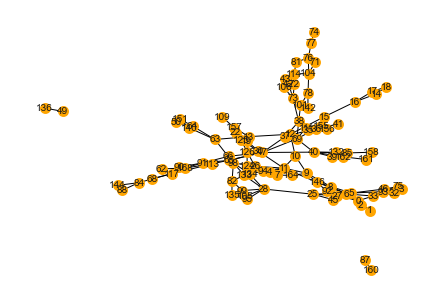

In [70]:
import networkx as nx

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=80, edge_color='black', linewidths=2, font_size=10,pos=nx.spring_layout(G))

In [ ]:
A = nx.adjacency_matrix(G)
A.todense()[0]

In [45]:
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()

## Failed Experiments :)

In [34]:
# one to one err
#input is (170)->1
lst_y=[]
lst_x=[]
for i in range(169):
    err_number=abs(prediction_of_one_student[i][i+1]-1)
    lst_y.append(err_number)
    lst_x.append(i)
    #print("err->",err_number,"sample",i)

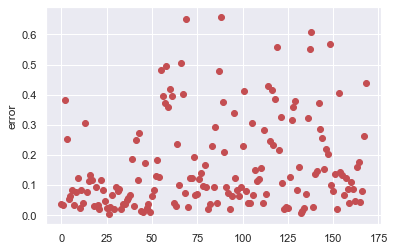

In [35]:
import matplotlib.pyplot as plt
plt.plot(lst_x,lst_y,"ro")
plt.ylabel('error')
plt.show()

In [36]:
lst_y1=[]
lst_x1=[]
for i in range(169):
    err_number=sum(abs(prediction_of_one_student[i][0:i+1]-1))/(i+1)
    lst_y1.append(err_number)
    lst_x1.append(i)
    #print("err->",err_number,"sample",i)

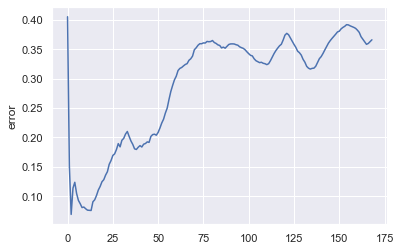

In [37]:
plt.plot(lst_x1,lst_y1)
plt.ylabel('error')
plt.show()

In [38]:
lst_y2=[]
lst_x2=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student[i][0:]-1))/(170)
    lst_y2.append(err_number)
    lst_x2.append(i)
    #print("err->",err_number,"sample",i)

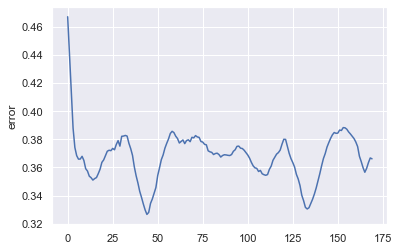

In [39]:
plt.plot(lst_x2,lst_y2)
plt.ylabel('error')
plt.show()

In [40]:
lst_y3=[]
lst_x3=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student[i][i:]-1))/(170-i)
    lst_y3.append(err_number)
    lst_x3.append(i)
    #print("err->",err_number,"sample",i)

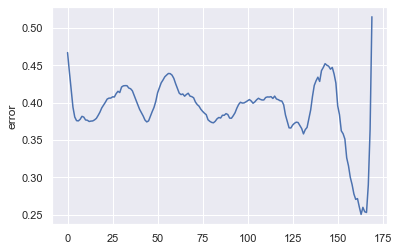

In [41]:
plt.plot(lst_x3,lst_y3)
plt.ylabel('error')
plt.show()

In [42]:
#shuffle the indexes
shuff_indexes=np.arange(170)
np.random.shuffle(shuff_indexes)


In [43]:
#create new
new_prediction=np.zeros((prediction_of_one_student.shape))

In [44]:
#shuffle the predictions
for j,i in enumerate(shuff_indexes):
    #print("j is",j , "i is ",i)
    new_prediction[j]=prediction_of_one_student[i]

In [45]:
lst_y4=[]
lst_x4=[]
for i in range(170):
    err_number=sum(abs(new_prediction[i][0:]-1))/(170)
    lst_y4.append(err_number)
    lst_x4.append(i)
    #print("err->",err_number,"sample",i)

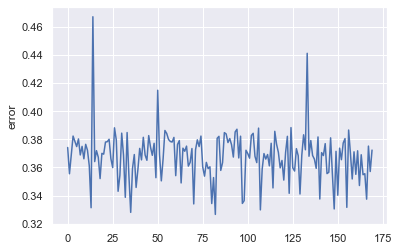

In [46]:
plt.plot(lst_x4,lst_y4)
plt.ylabel('error')
plt.show()

In [47]:
#now lets try giving shuffled input instead of shuffled output
#lets see the result
sample_shuff=np.zeros((1,170,340))
for i,j in enumerate(shuff_indexes):
    sample_shuff[0][i][2*j+1]=1

print("first sample")
print("i=",0,"j=",shuff_indexes[0])
print("value =",sample_shuff[0][0][2*shuff_indexes[0]+1])
#turn it into preper input for the model
shuffTensor=tf.convert_to_tensor(sample_shuff,dtype=float32)
#give input tensor to the  model
shuffTensor=tf.expand_dims(shuffTensor, axis=0)
#shuffled output
prediction_of_one_student_shuffled=student_model.predict(tf.squeeze(shuffTensor,axis=0))[0]


first sample
i= 0 j= 4
value = 1.0


In [48]:
lst_y5=[]
lst_x5=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student_shuffled[i][i:]-1))/(170-i)
    lst_y5.append(err_number)
    lst_x5.append(i)
    #print("err->",err_number,"sample",i)

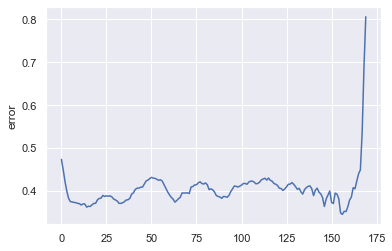

In [49]:
plt.plot(lst_x5,lst_y5)
plt.ylabel('error')
plt.show()

In [50]:
lst_y6=[]
lst_x6=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student_shuffled[i][0:]-1))/(170)
    lst_y6.append(err_number)
    lst_x6.append(i)
    #print("err->",err_number,"sample",i)

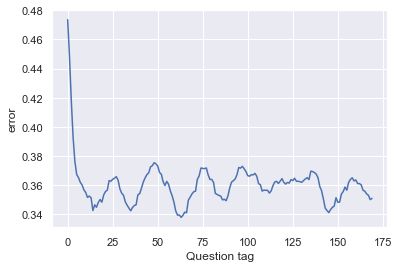

In [51]:
plt.plot(lst_x6,lst_y6)
plt.ylabel('error')
plt.xlabel('Question tag')

plt.show()

### prediction_on_given_data_set

In [ ]:
def prediction_on_given_data_set(d_set,prediction_set,student_answer_set):
    """
    This function makes prediction
    on given data set
    """
    for data_candidate in d_set:
        prediction_set.append(student_model.predict(data_candidate[0])[0])
        #set index 0 for 246,set 1 for 124
        temp=data_candidate[0]
        student_answer_set.append(temp[0])
    return prediction_set,student_answer_set